# Hello AtomDB!

This tutorial shows how to use QC-AtomDB as a Python library.


## Learning outcomes

- Loading/Dumping atomic species data

- Getting atomic properties

- Defining a pormolecule and evalauting its properties

## Packages isntall for Google Colab

In [1]:
# ! pip install git+https://github.com/theochem/iodata.git
# ! pip install git+https://github.com/theochem/grid.git
# ! pip install git+https://github.com/theochem/AtomDB.git@dev

In [2]:
# # download the example files
# import os
# from urllib.request import urlretrieve

# fpath = "data/"
# if not os.path.exists(fpath):
#     os.makedirs(fpath, exist_ok=True)

# urlretrieve(
#     "https://raw.githubusercontent.com/theochem/AtomDB/dev/examples/notebooks/data/h2o_dimer.xyz",
#     os.path.join(fpath, "h2o_dimer.xyz")
#     )

# urlretrieve(
#     "https://raw.githubusercontent.com/theochem/AtomDB/dev/examples/notebooks/data/h2o_promol_rho.npy",
#     os.path.join(fpath, "h2o_promol_rho.npy")
#     )

# urlretrieve(
#     "https://raw.githubusercontent.com/theochem/AtomDB/dev/examples/notebooks/data/h2o_promol_reducedgradient.npy",
#     os.path.join(fpath, "h2o_promol_reducedgradient.npy")
#     )

In [3]:
# import sys  
# sys.path.insert(0, '../../')

<!-- Atom-DB as a Python library
---------------------------- -->

The following lines should appear at the beginning of the scripts:

In [4]:
# Import the AtomDB library
import atomdb

# Optional modules
import numpy as np
from matplotlib import pyplot


## Loading/Dumping Data

Use the `atomdb.load` function to retrieve an atomic spcies' information.

The required inputs are: element symbol, charge and multiplicity. 

Optionally a dataset name can be specified choosing one of:

- `nist`: NIST spectroscopic data complemented with results from [Phys. Chem. Chem. Phys., 2016,18, 25721-25734](https://doi.org/10.1039/C6CP04533B)

- `slater`: Atomic orbitals and electronic denisty properties from SCF calculations using Slater basis.

- `numeric`: electronic denisty properties from numerical Hartree-fock calculations.

- `gaussian`: Atomic orbitals and electronic denisty properties from SCF calculations using gaussian basis. 

Currently we only support neutral/charged elements in its ground state, therefore, the optional parameter nexc (electronic state number) is not specified, leaving it to take its dafault value 0.

In [5]:
# Define species and load data
element = 'Cl'
charge = 0
mult = 2
dataset = 'slater'

chl = atomdb.load(element, charge, mult, dataset=dataset)



All information stored about a specise can be outputted in a JSON file format using:

In [6]:
# Dumping Data to a JSON File
# chl.to_json()

## Getting Atomic Properties

Bellow we showcase some of the accesible scalar and vector properties (mostly related to the electron density)
 
Note that we use dictionaries for properties like the non-bonded atomic radius having more than one definition.

* Scalars

In [7]:
print("Atomic number: ", chl.atnum)
print("Number of electrons: ", chl.nelec)
print("Mass [a.u.]: ", chl.atmass)
print("Atomic radius [a.u.]: ", chl.vdw_radius['bondi'])

Atomic number:  17
Number of electrons:  17
Mass [a.u.]:  {'stb': 64624.13119146579, 'nist': 63744.3189486301}
Atomic radius [a.u.]:  3.3070207180857714


* Vectors

In [8]:
# Atomic orbitals
print("Number of spin-orbitals (alpha): ", chl.ao.norba)
print("Energies: ", chl.ao.energy_a)
print("Occupations (alpha): ", chl.ao.occs_a)
print("Occupations (beta): ", chl.ao.occs_b)

Number of spin-orbitals (alpha):  9
Energies:  [-104.8844208  -10.6074807   -8.0722274   -8.0722274   -8.0722274
   -1.0729121   -0.5063999   -0.5063999   -0.5063999]
Occupations (alpha):  [1 1 1 1 1 1 1 1 1]
Occupations (beta):  [1 1 1 1 1 1 1 1 0]


* Functions (electron density properties)

Two methods are available to compute density-related properties: `dens_func` and `dens_func`; they return spline functions (cubic splines) that can be evaluated on a radial grid. 

<!-- Optionally, one can select the type of orbitals included in the calculation and take a subset of them by specifying their spin component and index, respectively (by default, all occupied alpha and beta spin-orbitals are included, `spin=ab` and `index=None`). Also, density derivatives are accessible through the `deriv` parameter passed to the splines. -->

In [9]:
# Define a uniform radial grid and evaluate density
rad_grid = np.linspace(0., 6., num=100)
dens_spline = chl.dens_func(log=True)

dens = dens_spline(rad_grid)

Text(0.5, 0.98, 'Spherically averaged density')

<Figure size 2400x1800 with 0 Axes>

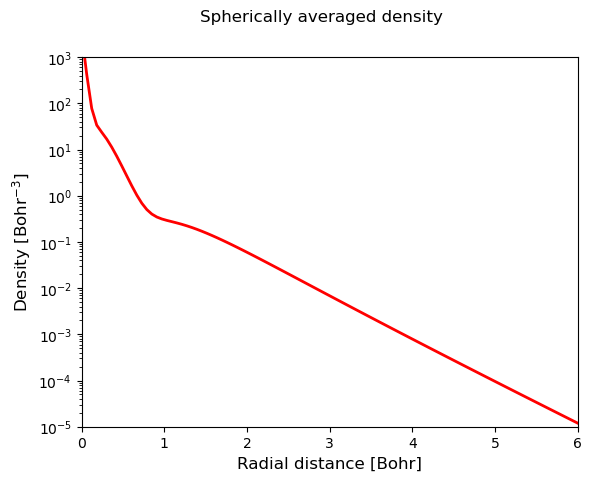

In [10]:
pyplot.figure(figsize = (8, 6), dpi=300)

# pyplot.rcParams.update({'font.size': 16})
params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 12,
         'axes.titlesize':16,
         'xtick.labelsize':10,
         'ytick.labelsize':10}
pyplot.rcParams.update(params)


fig, ax = pyplot.subplots()

ax.plot(rad_grid, dens, '-r', linewidth=2)

ax.set(xlabel="Radial distance [Bohr]", ylabel="Density [Bohr$^{-3}$]")
ax.set_yscale('log')
ax.set_ylim(top=1000, bottom=0.00001)
ax.set_xlim(left=0., right=6)
fig.suptitle(f'Spherically averaged density')

## Promolecule tool: making a pormolecule and evalauting its properties

#### Reduced density gradient

$$
s(\mathbf{r}) = \frac{1}{2(3\pi^2)^{1/3}}\frac{|\nabla \rho (\mathbf{r})|}{\rho^{4/3}(\mathbf{r})}
$$

To compute the reduced density gradient we need:
- Molecular coordinate file (e.g. XYZ file)
- Cubic grid of points
- Electron density and density gradient at points

[J. Chem. Theory Comput. 2011, 7, 3, 625–632](https://pubs.acs.org/doi/10.1021/ct100641a)

<img src="images/h2o_dimer.png" alt="drawing" style="width: 300px;"/>

The tool function `make_promolecule` in the `promolecule` module will build a promolecule for us. It is as simple as providing the list of atomic numbers and coordinates defining the molecule.

In [11]:
# Import modules
from atomdb import make_promolecule

# optional modules
from iodata import load_one
from grid.cubic import UniformGrid

In [12]:
# Define the molecule (atoms and coordinates)
fname = 'h2o'
mol = load_one(f'data/{fname}_dimer.xyz')
atnums = mol.atnums
atcoords = mol.atcoords

# Build de promolecule
dimer_promol = make_promolecule(atnums, atcoords, dataset='slater')

print("Atomic mass: ", dimer_promol.mass())
print("Electronic energy: ", -dimer_promol.energy())

Atomic mass:  65679.94820304772
Electronic energy:  151.618796918


The promolecule's electron density and density gradient are evaluated with the method `density`. In this example we use [Grid](https://github.com/theochem/grid) package to generate the required input set of points, but any external package with the same capabilities could be used.

In [13]:
# Generate a grid
cubgrid = UniformGrid.from_molecule(atnums, atcoords, spacing=0.2, extension=5.0, rotate=False, weight="Trapezoid")

# Evaluate the pormolecule's density
dimer_promol_rho = dimer_promol.density(cubgrid.points, log=True)
dimer_promol_nablarho = dimer_promol.gradient(cubgrid.points, log=True)

/Users/maximilianvanzyl/modules/AtomDB/atomdb/species.py:151: RuntimeWarning: invalid value encountered in log
  np.log(y) if log else y,


ValueError: `y` must contain only finite values.

In [ ]:
# Reduced density gradient
def reduced_density_gradient(rho, nablarho):
    coeff = 2 * (3 * np.pi ** 2) ** (1 / 3)
    gradnorm = np.linalg.norm(nablarho, axis=1)
    return gradnorm / (coeff * rho ** (4 / 3))


dimer_red_gradient = reduced_density_gradient(dimer_promol_rho, dimer_promol_nablarho)

In [ ]:
# Load desnity and reduced density data for a single H2O molecule
h2o_promol_rho = np.load(f'data/{fname}_promol_rho.npy')
h2o_red_gradient = np.load(f'data/{fname}_promol_reducedgradient.npy')

In [ ]:
#
# Reduced density gradient vs density for the promolecule
#
import matplotlib.pyplot as plt

plt.scatter(dimer_promol_rho, dimer_red_gradient, label='H2O dimer')
plt.scatter(h2o_promol_rho, h2o_red_gradient, label='H2O')
plt.xlim(0., 0.3)
plt.ylim(0., 1.0)
plt.xlabel(r'$\rho(R)$')
plt.ylabel(r'Reduced gradient')
plt.legend()
plt.show()